<a href="https://colab.research.google.com/github/Sahil-Sidana/DL_Project/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from subprocess import check_output
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.utils
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [ ]:
print(check_output(["ls", "/content/drive/MyDrive/sign_data/sign_data"]).decode("utf8"))

sign_data
test
test_data.csv
train
train_data.csv



In [ ]:
training_data="/content/drive/MyDrive/sign_data/sign_data/train"
training_csv="/content/drive/MyDrive/sign_data/sign_data/train_data.csv"
testing_csv="/content/drive/MyDrive/sign_data/sign_data/test_data.csv"
testing_data="/content/drive/MyDrive/sign_data/sign_data/test"

In [ ]:
class Config():
    training_data="/content/drive/MyDrive/sign_data/sign_data/train"
    testing_data="/content/drive/MyDrive/sign_data/sign_data/test"
    batch_size=64
    epochs=10

In [ ]:
class Loss(torch.nn.Module):
    def forward(self, output1, output2, label):
        difference=F.pairwise_distance(output1,output2)
        loss=torch.mean((1-label)*torch.pow(difference, 2)+(label)*torch.pow(torch.clamp(self.margin-difference,min=0.0),2))
        return loss

    def __init__(self,margin=2.0):
        super(Loss,self).__init__()
        self.margin=margin

In [ ]:
class SiameseNetwork(nn.Module):
    def forward_once(self,x):
        output=self.cnn1(x)
        output=output.view(output.size()[0],-1)
        output=self.fc1(output)
        return output

    def __init__(self):
        super(SiameseNetwork,self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1,96,kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3,stride=2),
            nn.Conv2d(96,256,kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3,stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,stride=2),
            nn.Dropout2d(p=0.3),
        )
        self.fc1=nn.Sequential(
            nn.Linear(30976,1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024,128),
            nn.ReLU(inplace=True),
            nn.Linear(128,2))

    def forward(self,input1,input2):
        output1=self.forward_once(input1)
        output2=self.forward_once(input2)
        return output1,output2

In [ ]:
class SiameseNetworkDataset():
    def __getitem__(self,index):
        image1_path=os.path.join(self.training_data,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_data,self.training_df.iat[index,1])
        picture1=Image.open(image1_path)
        picture2=Image.open(image2_path)
        picture1=picture1.convert("L")
        picture2=picture2.convert("L")
        if self.transform is not None:
            picture1=self.transform(picture1)
            picture2=self.transform(picture2)
        return picture1,picture2,torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

    def __init__(self,training_csv=None,training_data=None,transform=None):
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns=["image1","image2","label"]
        self.training_data=training_data
        self.transform=transform

In [ ]:
dataset=SiameseNetworkDataset(training_csv,training_data,transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75,8,text,style='italic',fontweight='bold',bbox={'facecolor':'red','alpha':0.8,'pad':20})
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

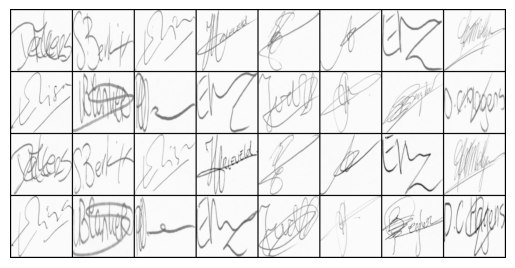

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [ ]:
visited_dataloader=DataLoader(dataset,shuffle=True,batch_size=16)
data_iter=iter(visited_dataloader)
example_batch=next(data_iter)
concatenated=torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
training_dataloader=DataLoader(dataset,shuffle=True,num_workers=8,batch_size=Config.batch_size)
network=SiameseNetwork().cuda()
loss1=Loss()
optimizer=optim.RMSprop(network.parameters(),lr=1e-4,alpha=0.99,eps=1e-8,weight_decay=0.0005,momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def training_model():
    for epoch in range(0,Config.epochs):
        for i, data in enumerate(training_dataloader,0):
            picture1,picture2,label=data
            picture1,picture2,label=picture1.cuda(),picture2.cuda(),label.cuda()
            optimizer.zero_grad()
            output1,output2 = network(picture1,picture2)
            loss = loss1(output1,output2,label)
            loss.backward()
            optimizer.step()
            if i % 100 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch+1,loss.item()))
    return network

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=training_model()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch number 1
 Current loss 1.6815192699432373

Epoch number 1
 Current loss 1.0015079975128174

Epoch number 1
 Current loss 1.2077112197875977

Epoch number 1
 Current loss 1.1441740989685059

Epoch number 2
 Current loss 1.202810287475586

Epoch number 2
 Current loss 1.2315374612808228

Epoch number 2
 Current loss 1.144359827041626

Epoch number 2
 Current loss 1.3376212120056152

Epoch number 3
 Current loss 1.183058261871338

Epoch number 3
 Current loss 1.2153961658477783

Epoch number 3
 Current loss 1.1489989757537842

Epoch number 3
 Current loss 1.1059291362762451

Epoch number 4
 Current loss 1.3855977058410645

Epoch number 4
 Current loss 1.1729133129119873

Epoch number 4
 Current loss 1.1637189388275146

Epoch number 4
 Current loss 1.3651872873306274

Epoch number 5
 Current loss 1.232267141342163

Epoch number 5
 Current loss 1.3154724836349487

Epoch number 5
 Current loss 1.0337485074996948

Epoch number 5
 Current loss 1.411010503768921

Epoch number 6
 Current l

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))
test_dataset=SiameseNetworkDataset(training_csv=testing_csv,training_data=testing_data,transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))
test_dataloader=DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


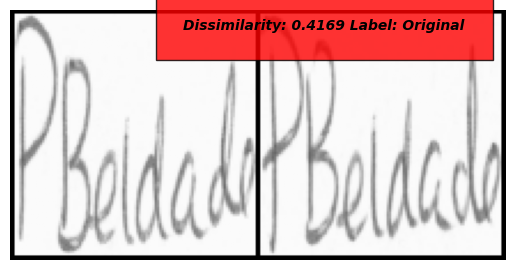

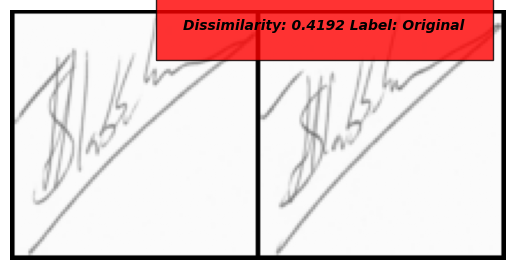

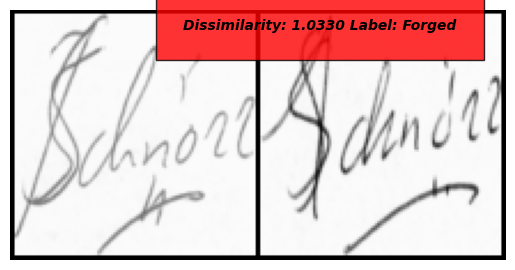

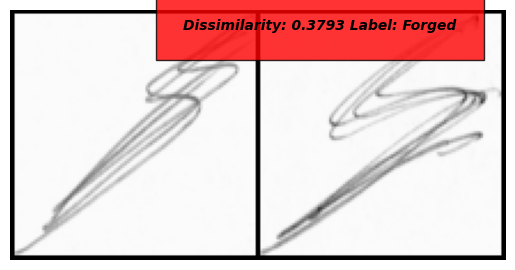

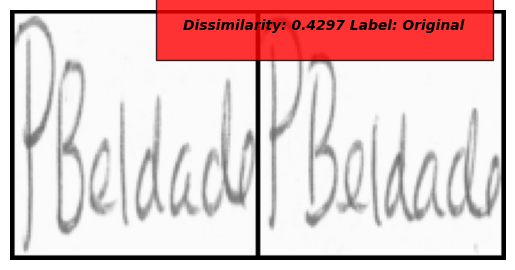

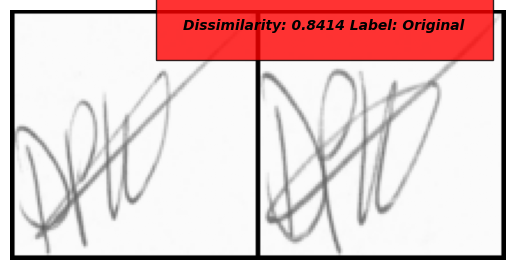

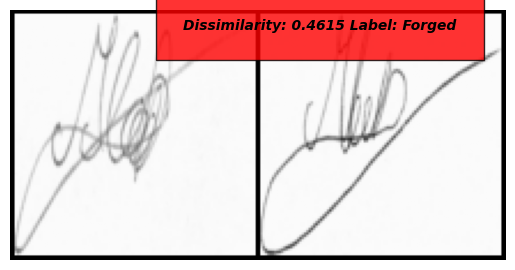

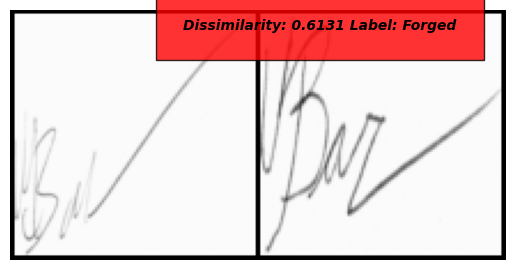

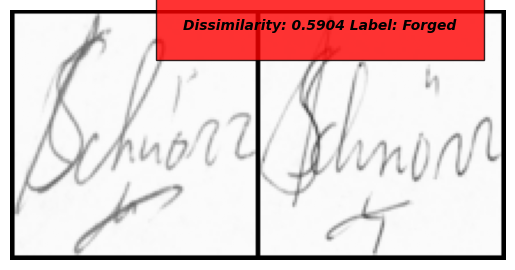

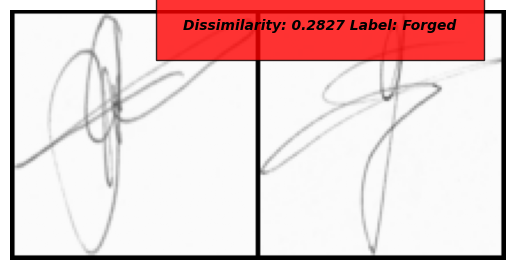

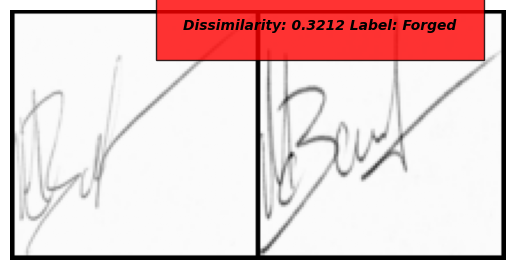

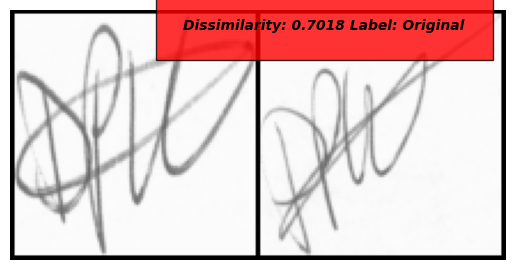

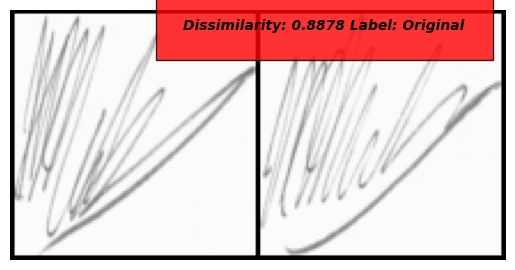

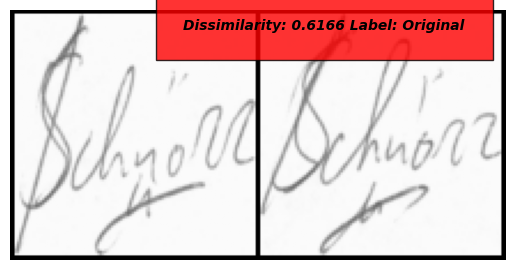

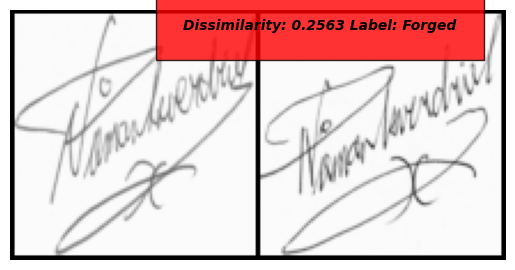

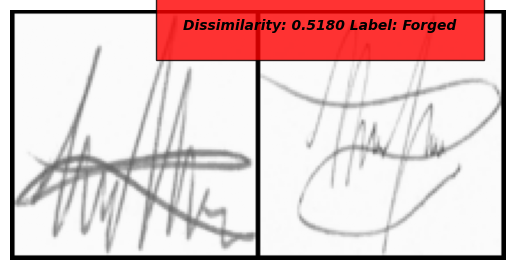

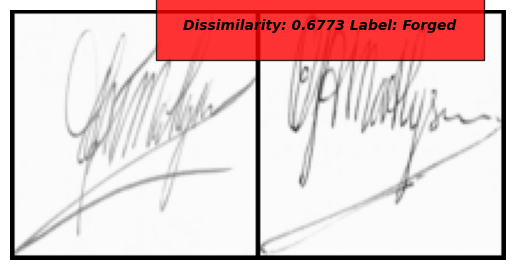

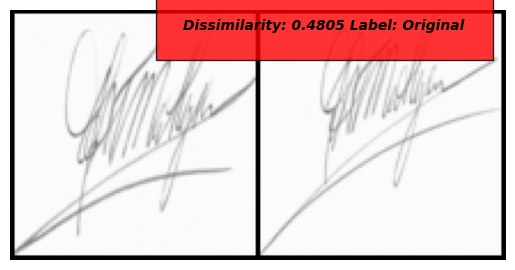

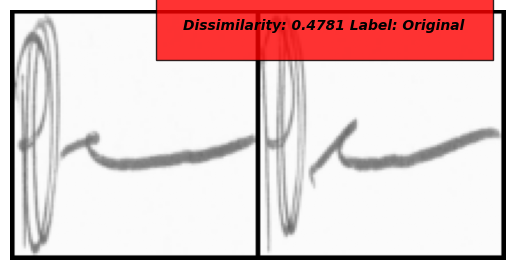

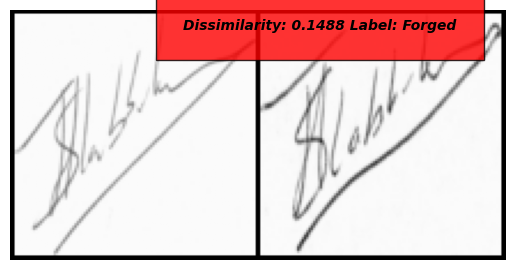

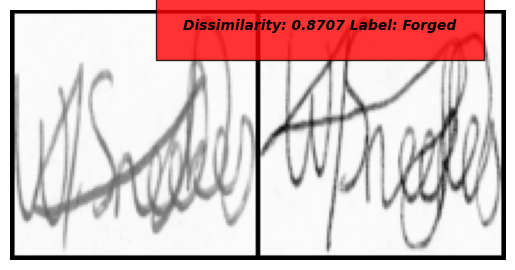

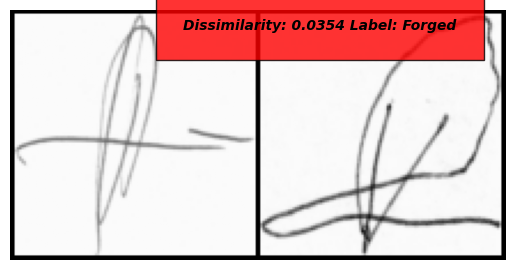

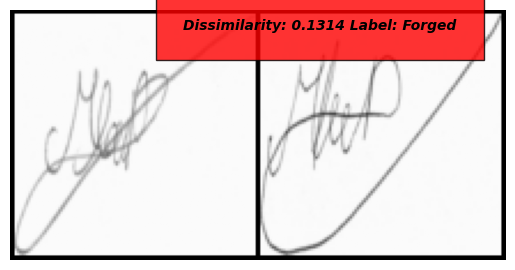

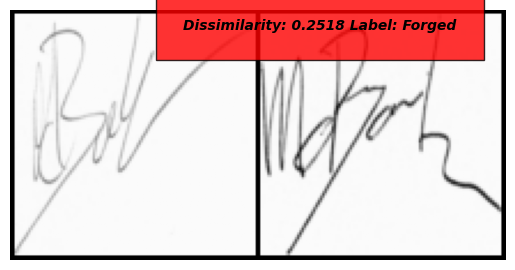

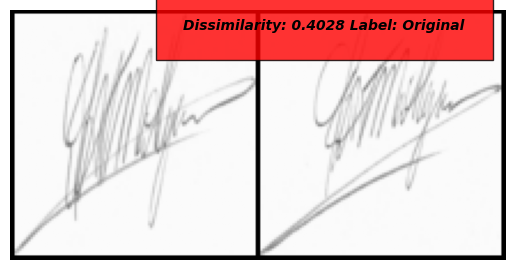

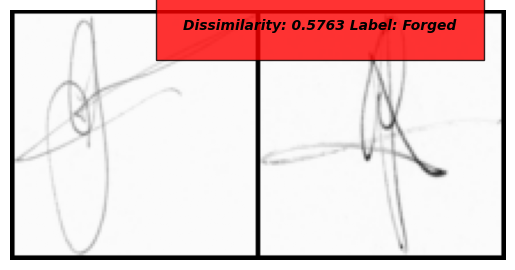

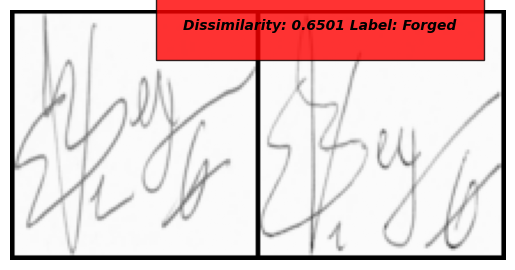

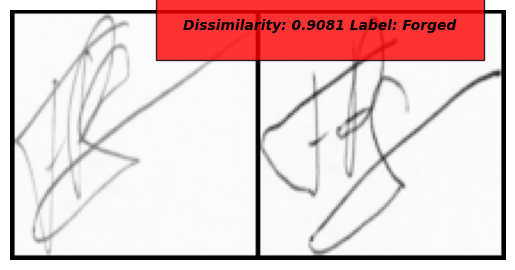

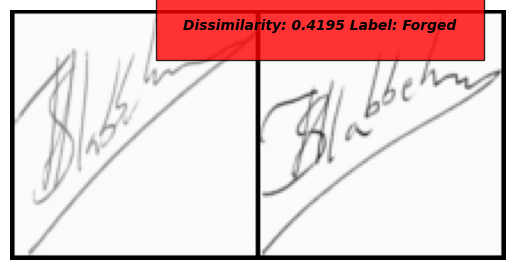

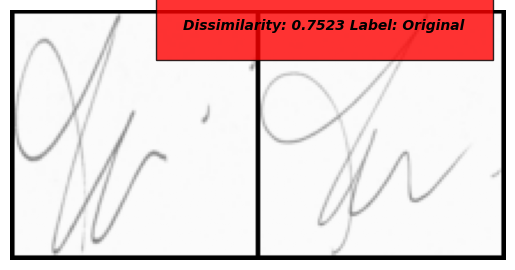

In [ ]:
c=0
list_0=torch.FloatTensor([[0]])
list_1=torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0):
  x0,x1,label=data
  concatenated=torch.cat((x0,x1),0)
  output1,output2=model(x0.to(device),x1.to(device))
  difference=F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Original"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.4f} Label: {}'.format(difference.item(),label))
  c+=1
  if c==30:
     break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Acurracy:  48.7360519965562


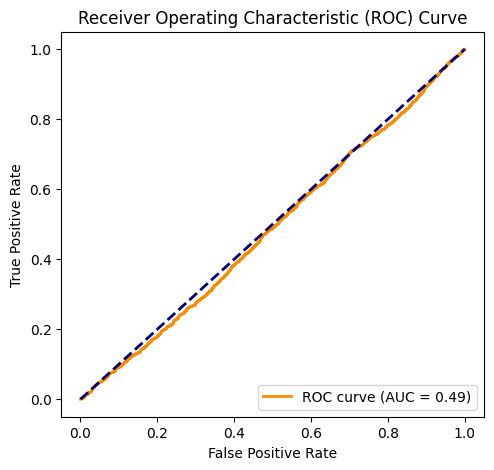

In [ ]:
predictions = []
true_labels = []
dissimilarity_scores = []
for data in test_dataloader:
        x0, x1, label = data
        concatenated=torch.cat((x0,x1),0)
        output1,output2=model(x0.to(device),x1.to(device))
        difference=F.pairwise_distance(output1, output2)
        predicted_label = 0 if difference.item() < 0.1 else 1
        true_label = label.item()
        predictions.append(predicted_label)
        true_labels.append(int(true_label))
        dissimilarity_scores.append(difference.item())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
dissimilarity_scores = np.array(dissimilarity_scores)
fpr, tpr, thresholds = roc_curve(true_labels, dissimilarity_scores)
roc_auc = auc(fpr, tpr)
print("Acurracy: ",100*roc_auc)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')